In [51]:
#Install libraries
!pip install huggingface_hub
!pip install huggingface
!pip install torch
!pip install transformers
!pip install scipy
!pip install nltk
!pip install scikit-learn
!pip install accelerate
!pip install seaborn
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 1.5 MB/s eta 0:00:00ta 0:00:01


In [42]:
# Importing
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
import warnings
import matplotlib.pyplot as plt

In [23]:
from csv import QUOTE_ALL
base_path = "/work/NLP"

#jigsaw dataset
jigsaw_df = pd.read_csv(
    "jigsaw_toxic_comment_train.csv",
    quoting=QUOTE_ALL,
    on_bad_lines="skip", 
    engine="python",  #Python parser
    encoding="utf-8",
) 

# Only necessary columns 
jigsaw_df = jigsaw_df[['comment_text', 'toxic']]  # Keep text and label

# Missing values
print(jigsaw_df.isnull().sum())

# Drop rows with missing values
jigsaw_df.dropna(inplace=True)

# Preview jigsaw
print("Jigsaw Dataset Sample:")
print(jigsaw_df.head())

print("Jigsaw Dataset Distribution:\n", jigsaw_df['toxic'].value_counts())




comment_text    0
toxic           0
dtype: int64
Jigsaw Dataset Sample:
                                        comment_text  toxic
0  Explanation\nWhy the edits made under my usern...      0
1  D'aww! He matches this background colour I'm s...      0
2  Hey man, I'm really not trying to edit war. It...      0
3  "\nMore\nI can't make any real suggestions on ...      0
4  You, sir, are my hero. Any chance you remember...      0
Jigsaw Dataset Distribution:
 toxic
0    100771
1     10714
Name: count, dtype: int64


In [24]:
# Split into training (80%) and validation (20%) - Jigsaw
X_train, X_val, y_train, y_val = train_test_split(
    jigsaw_df['comment_text'], jigsaw_df['toxic'], test_size=0.2, random_state=42
)

# Check sizes
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 89188
Validation set size: 22297


In [25]:
#Loading LoL dataset - initial look 
lol_df = pd.read_csv("LoL_toxic_tribunal_chatlogs.csv")  # Replace with your actual path

# Add binary label column to LoL dataset
lol_df = lol_df[['comment_text']]  # Assuming the text column is already named 'comment_text'

lol_df.dropna(inplace=True)

print(lol_df.head())

          comment_text
0           gold 2 zed
1                 IIII
2  nice premade lie :o
3                  ISI
4        smiteless pls


In [26]:
#average word length, we wanna consider the avg 
def calculate_avg_word_length(texts):
    total_words = sum(len(str(text).split()) for text in texts)
    total_sentences = len(texts)
    return total_words / total_sentences if total_sentences > 0 else 0

# each dataset
avg_word_length_jigsaw = calculate_avg_word_length(jigsaw_df['comment_text'])
print(f"Average Word Length in jigsaw Dataset: {avg_word_length_jigsaw:.2f}")

avg_word_length_lol = calculate_avg_word_length(lol_df['comment_text'])
print(f"Average Word Length in LoL Dataset: {avg_word_length_lol:.2f}")

Average Word Length in jigsaw Dataset: 67.51
Average Word Length in LoL Dataset: 2.87


In [7]:
# Load RoBERTa tokenizer 
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

#tokenization
def tokenize_data(comment_text, toxic):
    encodings = tokenizer(list(comment_text), truncation=True, padding=True, max_length=512, return_tensors="pt")
    dataset = torch.utils.data.TensorDataset(encodings["input_ids"], encodings["attention_mask"], torch.tensor(toxic))
    return dataset

# Tokenize training and validation dataset
train_dataset = tokenize_data(X_train, y_train.tolist())
val_dataset = tokenize_data(X_val, y_val.tolist())

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [8]:
# DataLoaders
#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=16)


In [9]:
#example tokenizing process
example = tokenizer(X_train.iloc[666], truncation=True, padding=True, max_length=512, return_tensors="pt")
print("Input IDs:", example['input_ids'])
print("Attention Mask:", example['attention_mask'])
print("Decoded Text:", tokenizer.decode(example['input_ids'][0]))



Input IDs: tensor([[    0, 11478, 26536,  2512,    47, 37019, 16954,   927,     2]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])
Decoded Text: <s>Go fuck yourself you lifeless pedant</s>


In [10]:
#defining the model1 
model1 = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#training param
training_param = TrainingArguments(
    output_dir="./results",  # Where to save model
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=10,  # Adjust if needed
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True
)

In [ ]:
from torch.utils.data import Dataset

class WrappedDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }

# Wrap datasets
train_dataset = WrappedDataset(
    input_ids=train_dataset.tensors[0],
    attention_mask=train_dataset.tensors[1],
    labels=train_dataset.tensors[2],
)

val_dataset = WrappedDataset(
    input_ids=val_dataset.tensors[0],
    attention_mask=val_dataset.tensors[1],
    labels=val_dataset.tensors[2],
)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
    }

warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.parallel._functions")


In [58]:
# Initialize Trainer
trainer = Trainer(
    model=model1,  # RoBERTa model 
    args=training_param,
    train_dataset=train_dataset,  
    eval_dataset=val_dataset, 
    compute_metrics=compute_metrics, #Eval params 
)


# Train the model
trainer.train()

NameError: name 'model1' is not defined

In [ ]:
model1.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")


In [35]:
# Load the fine-tuned model
model_path = "./fine_tuned_model"  # Replace with your saved model directory
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [7]:
# finally going to test on LoL dataset :) 

# Tokenize the LoL dataset
lol_encodings = tokenizer(
    list(lol_df["comment_text"]), 
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)

In [19]:
# Wrap the tokenized data in a Dataset
lol_dataset = torch.utils.data.TensorDataset(
    lol_encodings["input_ids"],
    lol_encodings["attention_mask"]
)
# Create TensorDataset
lol_dataset = TensorDataset(lol_encodings["input_ids"], lol_encodings["attention_mask"])
lol_loader = DataLoader(lol_dataset, batch_size=16)  # Adjust batch size if needed

In [38]:
from tqdm import tqdm #batch speed , my first model 
import numpy as np

all_preds_model1 = []

# Run Model 1 inference again
with torch.no_grad():
    for batch in tqdm(lol_loader, desc="Processing with Model 1"):
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        # Get model outputs
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)  # Get predicted class (0 = Non-Toxic, 1 = Toxic)
        
        all_preds_model1.extend(preds.cpu().numpy())

# Store Model 1 results in a new column
lol_df["model1_prediction"] = all_preds_model1

# Save Model 1 results separately
lol_df.to_csv("lol_predictions_model1.csv", index=False)
print("Model 1 predictions saved as lol_predictions_model1.csv")



Processing with Model 1: 100%|██████████| 65535/65535 [32:15<00:00, 33.87it/s]


Model 1 predictions saved as lol_predictions_model1.csv


In [39]:
lol_df["predicted_label"] = all_preds_model1  # Store results in DataFrame
lol_df.to_csv("lol_predictions_model1_check.csv", index=False)  # Save results
print("Predictions saved to lol_predictions.csv")

# Check % classified as toxic by Model 1
toxic_percentage_model1 = (lol_df["predicted_label"].sum() / len(lol_df)) * 100
print(f"Model 1 classified {toxic_percentage_model1:.2f}% of LoL comments as toxic.")


Predictions saved to lol_predictions.csv
Model 1 classified 10.04% of LoL comments as toxic.


/tmp/ipykernel_591/2119065583.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=toxic_counts.index, y=toxic_counts.values, palette=["green", "red"])


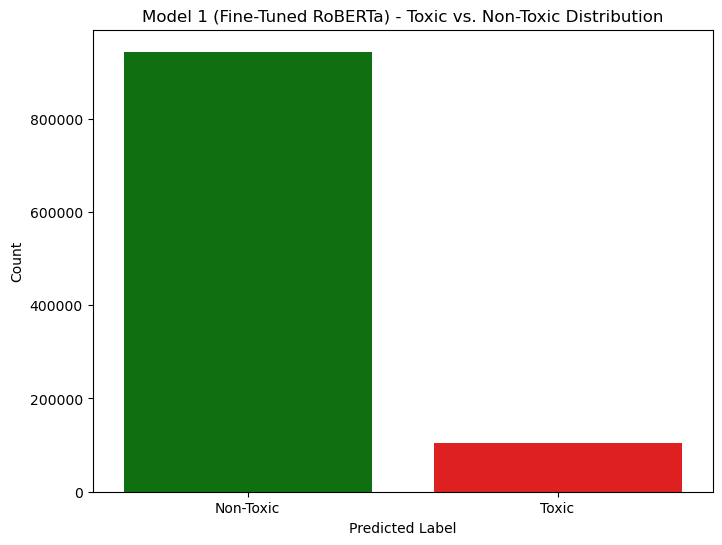

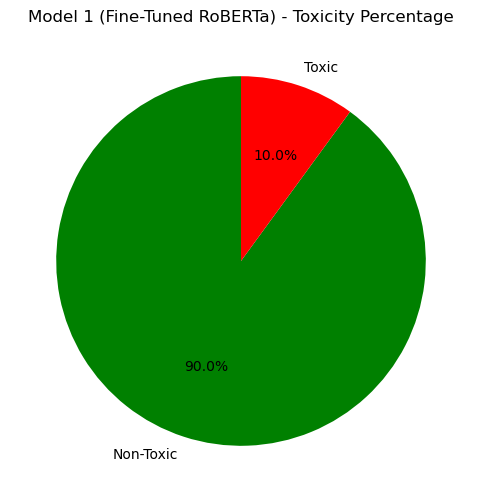

Visualizations saved in the 'NLP' folder.


In [45]:
#visuals for my model 1

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure the NLP folder exists
os.makedirs("NLP", exist_ok=True)

# Count the number of toxic and non-toxic predictions
toxic_counts = lol_df["predicted_label"].value_counts()

# Bar Plot: Distribution of Predictions
plt.figure(figsize=(8, 6))
sns.barplot(x=toxic_counts.index, y=toxic_counts.values, palette=["green", "red"])
plt.xticks([0, 1], ["Non-Toxic", "Toxic"])
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Model 1 (Fine-Tuned RoBERTa) - Toxic vs. Non-Toxic Distribution")
plt.savefig("model1_prediction_distribution.png")  # Save image
plt.show()

# Pie Chart: Percentage of Toxic vs. Non-Toxic
plt.figure(figsize=(6, 6))
plt.pie(toxic_counts, labels=["Non-Toxic", "Toxic"], autopct="%1.1f%%", colors=["green", "red"], startangle=90)
plt.title("Model 1 (Fine-Tuned RoBERTa) - Toxicity Percentage")
plt.savefig("model1_prediction_pie.png")  # Save image
plt.show()



In [46]:
### TOXIC- roberta-already pretrained - trying out 2nd model
import torch.nn.functional as F
toxic_model = RobertaForSequenceClassification.from_pretrained("unitary/unbiased-toxic-roberta")
toxic_tokenizer = RobertaTokenizer.from_pretrained("unitary/unbiased-toxic-roberta")

toxic_model.eval()  # Set to evaluation mode
toxic_model.to("cuda")  # using GPU 

# DataLoader- already ran with model 1
#lol_loader = torch.utils.data.DataLoader(lol_dataset, batch_size=16)

# Run Inference

all_preds_model2 = []

with torch.no_grad():
    for batch in tqdm(lol_loader, desc="Processing LoL Dataset with Toxic-RoBERTa"):
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to("cuda"), attention_mask.to("cuda")

        # Run the Toxic-RoBERTa model
        outputs = toxic_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)  # Convert logits to probabilities

        # **Threshold-based classification (if ANY category > 50%)**
        preds_any = (probs > 0.5).any(dim=1).int()  # Binary toxic vs. non-toxic

        all_preds_model2.extend(preds_any.cpu().numpy())  # Store predictions

# Store predictions
lol_df["toxic_roberta_prediction"] = all_preds_model2
lol_df.to_csv("lol_predictions_toxic_roberta.csv", index=False)

print("✅ Toxic-RoBERTa predictions saved to lol_predictions_toxic_roberta.csv")

# Check % classified as toxic
toxic_percentage = (lol_df["toxic_roberta_prediction"].sum() / len(lol_df)) * 100
print(f"Toxic-RoBERTa classified {toxic_percentage:.2f}% of LoL comments as toxic.")



Processing LoL Dataset with Toxic-RoBERTa: 100%|██████████| 65535/65535 [32:19<00:00, 33.80it/s]


✅ Toxic-RoBERTa predictions saved to lol_predictions_toxic_roberta.csv
Toxic-RoBERTa classified 39.23% of LoL comments as toxic.


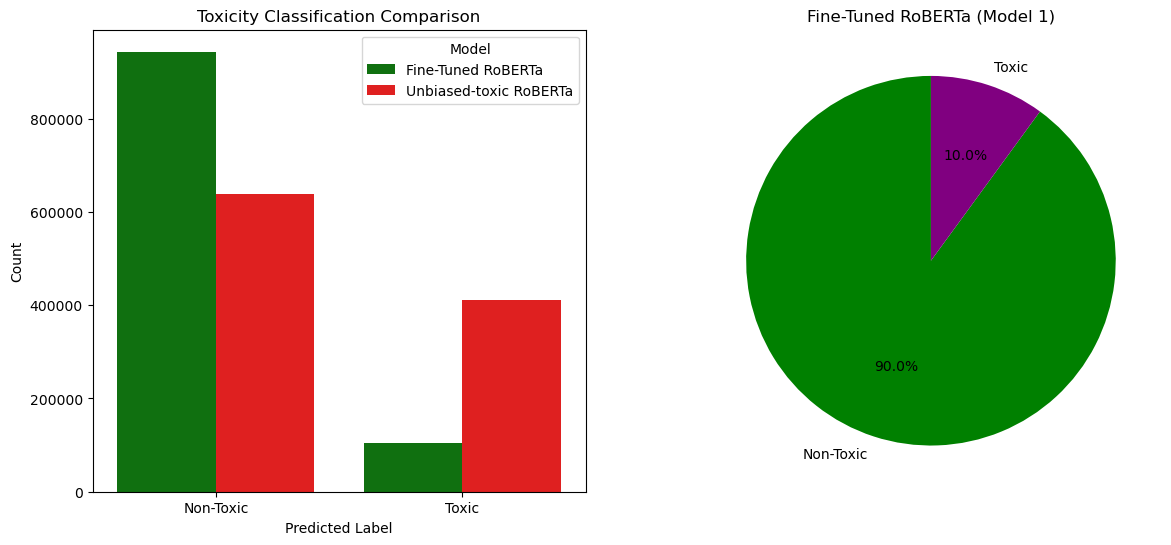

In [57]:
# Convert all Toxic-RoBERTa predictions where value >= 1 to 1 (toxic)
lol_df["toxic_roberta_binary"] = (lol_df["toxic_roberta_prediction"] >= 1).astype(int)

# Count toxic vs. non-toxic for both models
toxic_counts_model1 = lol_df["predicted_label"].value_counts().sort_index()
toxic_counts_roberta = lol_df["toxic_roberta_binary"].value_counts().sort_index()

# Create a figure with 2 subplots (Bar plot + Pie chart)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar Plot: Side-by-Side Comparison
toxicity_df = {
    "Model": ["Fine-Tuned RoBERTa"] * 2 + ["Unbiased-toxic RoBERTa"] * 2,
    "Label": ["Non-Toxic", "Toxic", "Non-Toxic", "Toxic"],
    "Count": [toxic_counts_model1[0], toxic_counts_model1[1], toxic_counts_roberta[0], toxic_counts_roberta[1]],
}

sns.barplot(x="Label", y="Count", hue="Model", data=toxicity_df, palette=["green", "red"], ax=axes[0])
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("Count")
axes[0].set_title("Toxicity Classification Comparison")
axes[0].legend(title="Model")

# Pie Chart: Percentage Comparison
labels = ["Non-Toxic", "Toxic"]
sizes_model1 = [toxic_counts_model1[0], toxic_counts_model1[1]]
sizes_roberta = [toxic_counts_roberta[0], toxic_counts_roberta[1]]

axes[1].pie(sizes_model1, labels=labels, autopct="%1.1f%%", colors=["green", "purple"], startangle=90)
axes[1].set_title("Fine-Tuned RoBERTa (Model 1)")

plt.savefig("model_comparison.png")  # Save the combined image
plt.show()

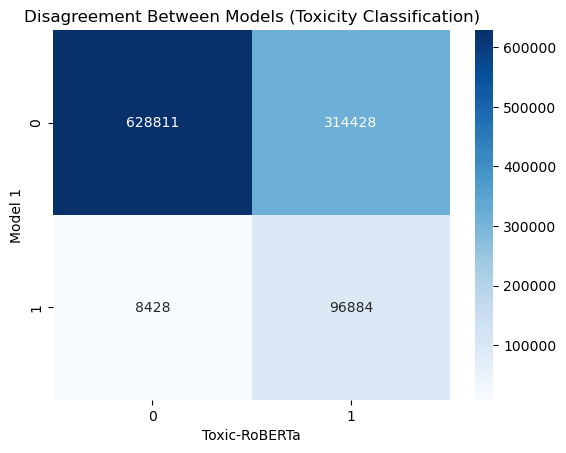

In [48]:
#overlap of models 
conf_matrix = pd.crosstab(lol_df["predicted_label"], lol_df["toxic_roberta_binary"], rownames=["Model 1"], colnames=["Toxic-RoBERTa"])
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")

plt.title("Disagreement Between Models (Toxicity Classification)")
plt.savefig("model_disagreement_heatmap.png")
plt.show()

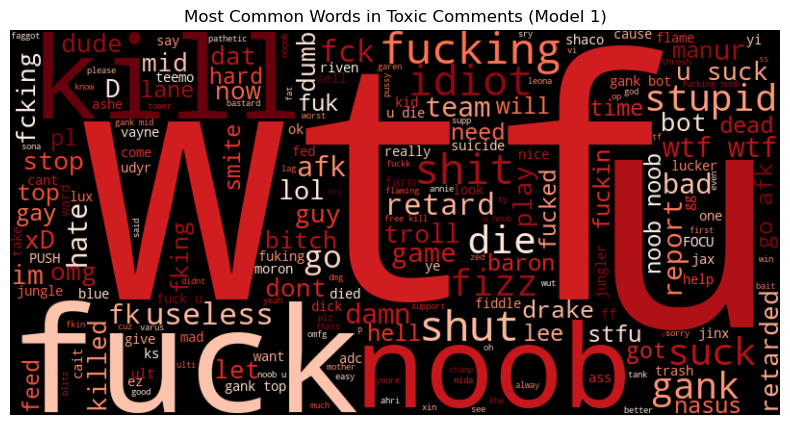

In [52]:
from wordcloud import WordCloud
#Which Words Are Flagged as Toxic the Most?
# Get text of toxic comments 
toxic_comments = " ".join(lol_df[lol_df["predicted_label"] == 1]["comment_text"])

# Generate and show word cloud
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(toxic_comments)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Toxic Comments (Model 1)")
plt.savefig("toxic_wordcloud.png")
plt.show()


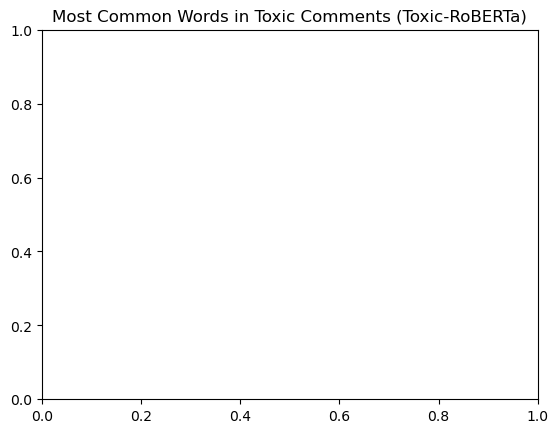

In [59]:
toxic_comments = " ".join(lol_df[lol_df["toxic_roberta_prediction"] == 1]["comment_text"])
plt.title("Most Common Words in Toxic Comments (Toxic-RoBERTa)")
plt.savefig("toxic_wordcloud_roberta.png")


In [53]:
#Distribution of Toxicity Probability Scores Histogram - model 2 
plt.figure(figsize=(8, 5))
sns.histplot(lol_df["toxic_roberta_prob"], bins=20, kde=True, color="red")
plt.xlabel("Toxicity Probability Score")
plt.ylabel("Count")
plt.title("Toxic-RoBERTa: Distribution of Toxicity Scores")
plt.savefig("toxicity_score_distribution.png")
plt.show()


KeyError: 'toxic_roberta_prob'

<Figure size 800x500 with 0 Axes>